# Code for Stochatic parameter shift rule single phase

In [1]:
pip install qiskit
pip install tqix

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
from qiskit import QuantumCircuit
import qiskit
from tqix import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Pauli matrices # from tqix
sx = sigmax()
sy = sigmay()
sz = sigmaz()
si = eyex(2)
u = obasis(2,0)
d = obasis(2,1)

## Trotter for single paramter

In [4]:
# Define U(x,z)
def uxz(qc,x,z,m):
    qc.h(0) 
    for j in range (m):
        qc.rx(x,0)
        qc.rz(z,0)
    return qc

# Define evolved state
def istate(qc,m,t,theta):
    x = 2*t/m*np.cos(theta)
    z = 2*t/m*np.sin(theta)
    qct = uxz(qc,x,z,m)
    psi = qiskit.quantum_info.Statevector.from_instruction(qct)
    psi = psi.data.reshape((2,1))
    return psi 

# Define derivative
def dev(qc,create_circuit_func,x,z,m,t,theta):
    gradient = []
    x1, z1 = x.copy(), z.copy()
    x1 += np.pi
    z1 += np.pi

    qcx = create_circuit_func(qc.copy(),x1,z,m)
    qcz = create_circuit_func(qc.copy(),x,z1,m)
    dx1 = qiskit.quantum_info.Statevector.from_instruction(qcx).data
    dz1 = qiskit.quantum_info.Statevector.from_instruction(qcz).data
    
    res = -t*np.sin(theta)*dx1 + t*np.cos(theta)*dz1
    return res

In [5]:
# run code 
t = np.linspace(0,np.pi,100)
m = 401
nums = [3,6]


qc = qiskit.QuantumCircuit(1, 1)
create_circuit_func = uxz

for num in nums:
    theta = np.pi/num  
    dat = []  
    for i in t:
        psi = istate(qc.copy(),m,i,theta)
        x = 2*i/m*np.cos(theta)
        z = 2*i/m*np.sin(theta)
        res = dev(qc.copy(),create_circuit_func,x,z,m,i,theta)
        dpsi = res.reshape((2,1))
        gr = 4*(np.dot(dpsi.conj().T,dpsi)-np.dot(dpsi.conj().T,psi)*np.dot(psi.conj().T,dpsi))
        dat.append(np.real(gr[0,0]))
    globals()['qfi_pi%s' % str(num)] = np.real(dat)  
    np.savetxt('data/qfi_pi%s'%str(num), np.real(dat), delimiter=',')  

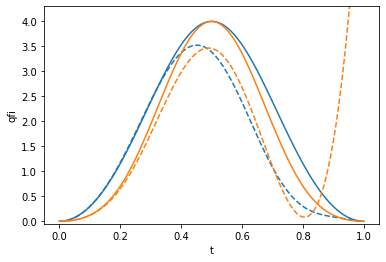

In [6]:
cmap = plt.get_cmap("tab10")

y3 = -4*np.sin(t)**2 * (-1 + np.cos(t)**2 * np.sin(np.pi/3)**2)
y6 = -4*np.sin(t)**2 * (-1 + np.cos(t)**2 * np.sin(np.pi/6)**2)

plt.plot(t/np.pi,y6, 'r',color=cmap(0))
plt.plot(t/np.pi,qfi_pi6, 'r--',color=cmap(0))

plt.plot(t/np.pi,y3, 'g',color=cmap(1))
plt.plot(t/np.pi,qfi_pi3, 'g--',color=cmap(1))

plt.xlabel("t")
plt.ylabel("qfi")
plt.ylim(-0.05,4.3)
plt.show()

In [6]:
## Stoct. PSR

In [7]:
from scipy.linalg import expm
psi0 = 1/np.sqrt(2)*np.array([[1],[1]])

def Ham(theta):
    return np.cos(theta)*sx + np.sin(theta)*sz

def evol(theta,t):
    return expm(-1j*t*Ham(theta))

def psit(theta,t):
    return dotx(evol(theta,t),psi0) 

In [8]:
# para-shift
def shif(theta,t,s,pm):
    dH = np.array([[np.cos(theta),-np.sin(theta)],[-np.sin(theta),-np.cos(theta)]])
    return dotx(evol(theta,(t-s)),expm(pm*1j*np.pi/4*dH),evol(theta,s),psi0)

def der(theta,t,s):
    return shif(theta,t,s,-1) - shif(theta,t,s,1) 

In [9]:
# run the program
Ns = 1000
t = np.linspace(0,np.pi,100)
nums = [3,6]

for num in nums:
    theta = np.pi/num
    dat = []
    for i in t:
        rs = 0.0
        for j in range(Ns):
            s = np.random.uniform(0, i) #np.random.random()*i
            rs += i/(2*np.sin(np.pi/4))*der(theta,i,s) # following Monte-Carlo sampling
        rs /= Ns
        Li01 = dotx(rs.conj().T,rs)
        Li02 = dotx(rs.conj().T,psit(theta,i))
        Li03 = dotx(psit(theta,i).conj().T,rs)
        QLs = 4*np.real((Li01 - Li02*Li03))
        dat.append(QLs[0,0]) 
    globals()['qfi_SPR%s' % str(num)] = np.real(dat)  
    np.savetxt('data/qfi_SPR%s'%str(num), np.real(dat), delimiter=',')      

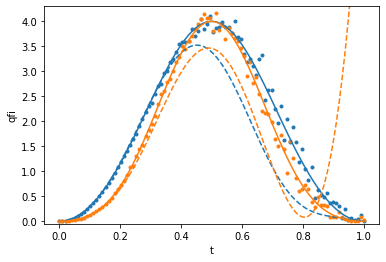

In [10]:
cmap = plt.get_cmap("tab10")

y6 = -4*np.sin(t)**2*(-1 + np.cos(t)**2*np.sin(np.pi/6)**2)
y3 = -4*np.sin(t)**2*(-1 + np.cos(t)**2*np.sin(np.pi/3)**2)

plt.scatter(t/np.pi,qfi_SPR6,marker='.',color=cmap(0))
plt.plot(t/np.pi,y6, 'r',color=cmap(0))
plt.plot(t/np.pi,qfi_pi6, 'r--',color=cmap(0))

plt.scatter(t/np.pi,qfi_SPR3,marker='.',color=cmap(1))
plt.plot(t/np.pi,y3, 'g',color=cmap(1))
plt.plot(t/np.pi,qfi_pi3, 'g--',color=cmap(1))

plt.xlabel("t")
plt.ylabel("qfi")
plt.ylim(-0.05,4.3)
plt.savefig('data/fig_single.eps', format = 'eps', dpi=600)
plt.show()